<h1><center>RQ1</center></h1>
<center>Marcel de Cabanyes Torras</center>
<center> 207526</center>

## Preparation

In [1]:
import os.path
import sys
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(parent_dir, 'search-engine/')) #Load utils.py from search-engine/
from utils import *
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import preprocess_string
from sklearn.manifold import TSNE
import nltk
nltk.download('punkt') # used in sent_tokenize
from sklearn.cluster import KMeans, DBSCAN
pd.set_option('display.max_colwidth', -1)

[nltk_data] Downloading package stopwords to /home/marcel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/marcel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Firstly we are going to recreate the work of the search engine (using the same functions from utils): reprocessing and index creation.

In [2]:
data_dir = os.path.join(parent_dir, 'search-engine/data') #Load data from search-engine/data
start_time = time.time()

df_tweets_simp = preprocess(data_dir) # Preprocess dataset

print("Total time to preprocess dataset of {} tweets: {} seconds." .format(len(df_tweets_simp),np.round(time.time() - start_time,2)))

start_time = time.time()
print("\n======================\nCreating index...")
numTweets = len(df_tweets_simp)
myIndex, df, idf = create_index_tfidf(df_tweets_simp,numTweets) # Create indices
print("Total time to create the index: {} seconds." .format(np.round(time.time() - start_time,2)))


Loading dataset...

Preprocessing dataset...
Total time to preprocess dataset of 100100 tweets: 55.45 seconds.

Creating index...
10001 tweets have been indexed in  2.74 seconds.
20001 tweets have been indexed in  5.18 seconds.
30001 tweets have been indexed in  7.61 seconds.
40001 tweets have been indexed in  10.03 seconds.
50001 tweets have been indexed in  12.85 seconds.
60001 tweets have been indexed in  15.59 seconds.
70001 tweets have been indexed in  18.17 seconds.
80001 tweets have been indexed in  20.73 seconds.
90001 tweets have been indexed in  23.06 seconds.
100001 tweets have been indexed in  25.28 seconds.
Creating df and idf...
Total time to create the index: 25.87 seconds.


## Query selection 
### (Question a)

Set the queries we want to submit and the columns.

In [3]:
myQueries = ['covid',
            'vaccine',
            'trump',
            'disease',
            'biden',
            'lockdown',
            'ball',
            'when will we have a vaccine?',
            'has Trump passed the covid?',
            'where should i wear a mask?']
top = 20
columns = ['text', 'user', 'date', 'hashtags', 'likes', 'retweets', 'url', 'score']
out_columns = ['query', 'text', 'user', 'date', 'hashtags', 'likes', 'retweets', 'url', 'score']
output_dir = os.path.join(parent_dir, 'other-outputs/')

## TF-IDF + cosine similarity ranking
### (Question b)

Now we are going to override the functions `sumbit_search` and `rank` in order to automate them (they will not ask the user for the query or the type of ranking, but rather it is passed directly as a parameter)

In [4]:
def submit_search(top, index, df_tweets, myQuery):
    start_time = 0
    #Gets the result of the query
    result_tweets = pd.DataFrame()

    start_time = time.time()
    result_tweets = search(myQuery, index, df_tweets)
    if len(result_tweets) == 0:
        print("\n======================\nNo matches found.")
    return result_tweets


def rank(top, result_tweets, index, idf, myQuery, method):
    print("\n======================\nLoading inverse document frequencies...")
    print("Inverse document frequencies loaded.")
    columns = ['text', 'user', 'date', 'hashtags', 'likes', 'retweets', 'url', 'score']
    methods_dict = {"1":tfidf_rank,"2":popularity_rank}
    selection = method
    ranked_tweets = pd.DataFrame()
    start_time = 0
    start_time = time.time()
    ranked_tweets = methods_dict[selection](myQuery, result_tweets, index, idf, top)
    
    if len(ranked_tweets) == 0:
        print("\n======================\nNo matches were found.")
    print("Total time to rank the tweets: {} seconds." .format(np.round(time.time() - start_time,2)))
    return ranked_tweets[columns].reset_index(drop=True)

For each query in my query, rank it.

In [5]:
queries_df = pd.DataFrame(columns = out_columns)
for query in myQueries:
    result_tweets = submit_search(top, myIndex, df_tweets_simp, query)
    ranked_tweets = rank(top, result_tweets, myIndex, idf, query, "1") # Method "1" corresponds to tf-idf
    ranked_tweets['query'] = query
    queries_df = pd.concat([queries_df, ranked_tweets[out_columns]], sort=False)


Loading inverse document frequencies...
Inverse document frequencies loaded.
Total time to rank the tweets: 12.27 seconds.

Loading inverse document frequencies...
Inverse document frequencies loaded.
Total time to rank the tweets: 1.41 seconds.

Loading inverse document frequencies...
Inverse document frequencies loaded.
Total time to rank the tweets: 2.97 seconds.

Loading inverse document frequencies...
Inverse document frequencies loaded.
Total time to rank the tweets: 0.19 seconds.

Loading inverse document frequencies...
Inverse document frequencies loaded.
Total time to rank the tweets: 1.35 seconds.

Loading inverse document frequencies...
Inverse document frequencies loaded.
Total time to rank the tweets: 2.71 seconds.

Loading inverse document frequencies...
Inverse document frequencies loaded.
Total time to rank the tweets: 0.03 seconds.

Loading inverse document frequencies...
Inverse document frequencies loaded.
Total time to rank the tweets: 1.44 seconds.

Loading invers

Save to other-outputs.

In [6]:
output_filename = os.path.join(output_dir, 'RQ1_b.tsv')
queries_df.to_csv(output_filename, sep = '\t')

## Word2Vec + cosine similarity
### (Question c)

In [7]:
# Functions for vector embedding        

# Splits into sentences
def get_sentences(tweets, stops, verbose=10000):
    #loop over all docs (paragraphs in our case)
    lines = len(tweets)
    for i, tweet in enumerate(tweets):        
        # use nltk.sent_tokenize to split paragraphs into sentences
        for s in nltk.sent_tokenize(tweet):
            # preprocess each sentence using gensim (return string not list)
            yield ' '.join(getTerms(s, stops))
        # print progress if needed
        if verbose > 0 and (i + 1) % verbose == 0:
            print("Progress: {}%.".format(np.round((i/lines)*100,2)))
    print("Progress: 100%.") 

# Generates w2v model
def create_w2v_model(df_tweets, stops):
    # Get texts as list
    tweets = list(df_tweets['text'])
    # Get sentences
    sentences = list(get_sentences(tweets,stops))
    # Split in words
    words = [s.split() for s in sentences ]
    #Create model
    print("\n======================\nGenerating model...")
    w2v_model = Word2Vec(sentences = words, size = 100, window = 10, min_count = 10, negative = 15, sg = 0)
    return w2v_model

# Transforms set of terms (tweet) into vector (averaging the terms vectors)
def get_vector(w2v_model, terms):
    vector = 0
    count = 0
    for term in terms: # Gets the vector for each term of the tweet
        if w2v_model.wv.__contains__(term):
            vector += w2v_model.wv.__getitem__(term)
            count += 1
    avg_vector = vector/count # Averages it
    #norm_vector = avg_vector / np.linalg.norm(avg_vector) # Normalizes it
    return avg_vector

def w2v_rank(top, myQuery, stops, w2v_model, result_tweets):
    query_terms = getTerms(myQuery, stops) # Get query terms
    query_vector = get_vector(w2v_model, query_terms) # Get query vector from model
    top_20 = topper(top) # Class defined in utils to retain the topX values
    for i, tweet in result_tweets.iterrows():
        tweet_vector = get_vector(w2v_model,tweet['terms']) # Get tweet vector
        score = np.dot(query_vector, tweet_vector)  # Compute the score as the dot product
        top_20.append(tweet['id'], score)
    top_20.sort()
    rankedTweets = top_20.to_dataframe('id', 'score')
    rankedTweets = pd.merge(rankedTweets,result_tweets, on='id',how='left')
    return rankedTweets 

Train the model model.

In [8]:
stops = set(stopwords.words('english'))
w2v_model = create_w2v_model(df_tweets_simp, stops)

Progress: 9.99%.
Progress: 19.98%.
Progress: 29.97%.
Progress: 39.96%.
Progress: 49.95%.
Progress: 59.94%.
Progress: 69.93%.
Progress: 79.92%.
Progress: 89.91%.
Progress: 99.9%.
Progress: 100%.

Generating model...


Search the tweets and rank them using w2v for each query.

In [9]:
queries_df = pd.DataFrame(columns = out_columns)
for query in myQueries:
    result_tweets = submit_search(top, myIndex, df_tweets_simp, query)
    ranked_df = w2v_rank(top, query, stops, w2v_model, result_tweets)
    ranked_df['query'] = query
    queries_df = pd.concat([queries_df, ranked_df[out_columns]])

Save to other-outputs.

In [10]:
output_filename = os.path.join(output_dir, 'RQ1_c.tsv')
queries_df.to_csv(output_filename, sep = '\t')

## Embedded representation of the collection
### (Question c)

We select a subset of the tweets so that it is computationally feasible for us.

In [11]:
df_tweets_simp_red = df_tweets_simp[:20000]

We convert each tweet to vector and the we stack them together in a matrix.

In [12]:
count = 0
lines = len(df_tweets_simp_red)
list_embedded_tweets = [] # this list of indexes will help us later to link the tweet to its vector
for i, tweet in df_tweets_simp_red.iterrows():
    try:
        tweet_vector = get_vector(w2v_model,tweet['terms']) # get vector representation
        if count == 0:
            tweets_array = np.array(tweet_vector) # if its the first tweet, initialize the matrix
            list_embedded_tweets.append(i)
            count += 1
        else:
            tweets_array = np.vstack((tweets_array, np.array(tweet_vector))) # if not, stack it
            count += 1
            list_embedded_tweets.append(i)

    except:
        continue
    if(i % 2000 == 0):
        print("{}% of tweets have been converted to vectors.".format(round((i/lines)*100,2)))
print("100% of tweets have been converted to vectors.")

0.0% of tweets have been converted to vectors.
10.0% of tweets have been converted to vectors.
20.0% of tweets have been converted to vectors.
30.0% of tweets have been converted to vectors.
40.0% of tweets have been converted to vectors.
50.0% of tweets have been converted to vectors.
60.0% of tweets have been converted to vectors.
70.0% of tweets have been converted to vectors.
80.0% of tweets have been converted to vectors.
90.0% of tweets have been converted to vectors.
100% of tweets have been converted to vectors.


We use tsne in order to embed the matrix of tweets in a 2 dimensional space.

In [13]:
X_embedded = TSNE(n_components=2, verbose=2).fit_transform(tweets_array)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 19912 samples in 0.075s...
[t-SNE] Computed neighbors for 19912 samples in 75.546s...
[t-SNE] Computed conditional probabilities for sample 1000 / 19912
[t-SNE] Computed conditional probabilities for sample 2000 / 19912
[t-SNE] Computed conditional probabilities for sample 3000 / 19912
[t-SNE] Computed conditional probabilities for sample 4000 / 19912
[t-SNE] Computed conditional probabilities for sample 5000 / 19912
[t-SNE] Computed conditional probabilities for sample 6000 / 19912
[t-SNE] Computed conditional probabilities for sample 7000 / 19912
[t-SNE] Computed conditional probabilities for sample 8000 / 19912
[t-SNE] Computed conditional probabilities for sample 9000 / 19912
[t-SNE] Computed conditional probabilities for sample 10000 / 19912
[t-SNE] Computed conditional probabilities for sample 11000 / 19912
[t-SNE] Computed conditional probabilities for sample 12000 / 19912
[t-SNE] Computed conditional probabilities for sa

Now we are going to represent the embedding.

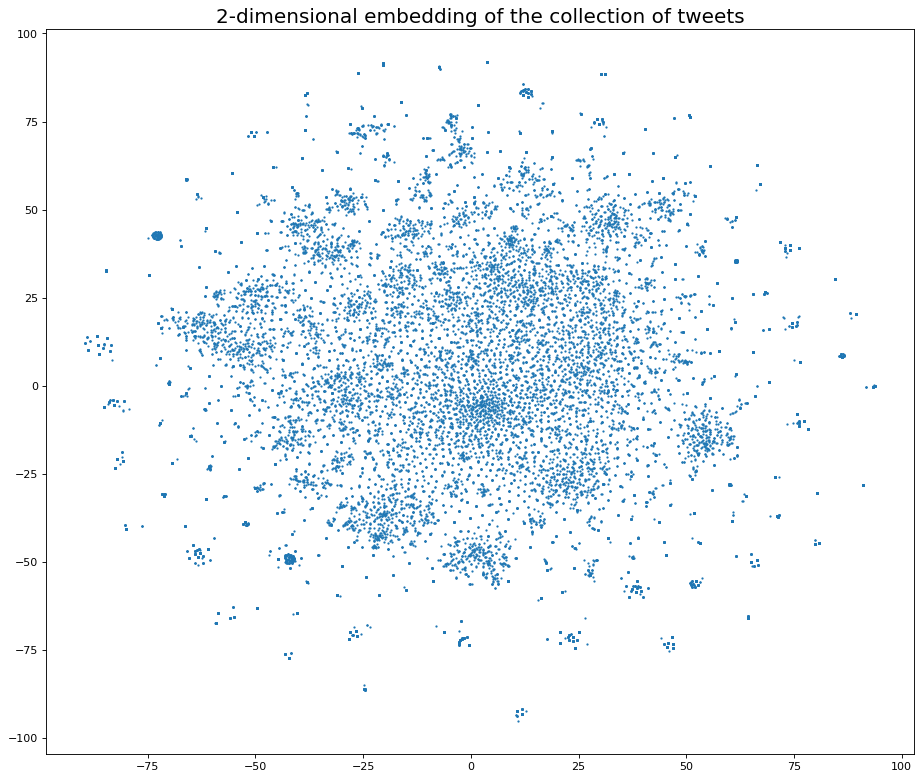

In [14]:
plt.figure(num=None, figsize=(14, 12), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(x = X_embedded[:,0], y = X_embedded[:,1], s = 1)
plt.title('2-dimensional embedding of the collection of tweets', fontsize=18)
plt.show()

## Clustering
### RQ 1A

We compute the inertias (error) for a range of number of clusters.

In [15]:
inertias = []
for k in range(1,50,1):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_embedded)  # fit
    inertias.append(kmeans.inertia_) # get inertia
    print("Computed inertia for {} clusters.".format(k))

Computed inertia for 1 clusters.
Computed inertia for 2 clusters.
Computed inertia for 3 clusters.
Computed inertia for 4 clusters.
Computed inertia for 5 clusters.
Computed inertia for 6 clusters.
Computed inertia for 7 clusters.
Computed inertia for 8 clusters.
Computed inertia for 9 clusters.
Computed inertia for 10 clusters.
Computed inertia for 11 clusters.
Computed inertia for 12 clusters.
Computed inertia for 13 clusters.
Computed inertia for 14 clusters.
Computed inertia for 15 clusters.
Computed inertia for 16 clusters.
Computed inertia for 17 clusters.
Computed inertia for 18 clusters.
Computed inertia for 19 clusters.
Computed inertia for 20 clusters.
Computed inertia for 21 clusters.
Computed inertia for 22 clusters.
Computed inertia for 23 clusters.
Computed inertia for 24 clusters.
Computed inertia for 25 clusters.
Computed inertia for 26 clusters.
Computed inertia for 27 clusters.
Computed inertia for 28 clusters.
Computed inertia for 29 clusters.
Computed inertia for 30

We represent the `error` vs `number of clusters` curve.

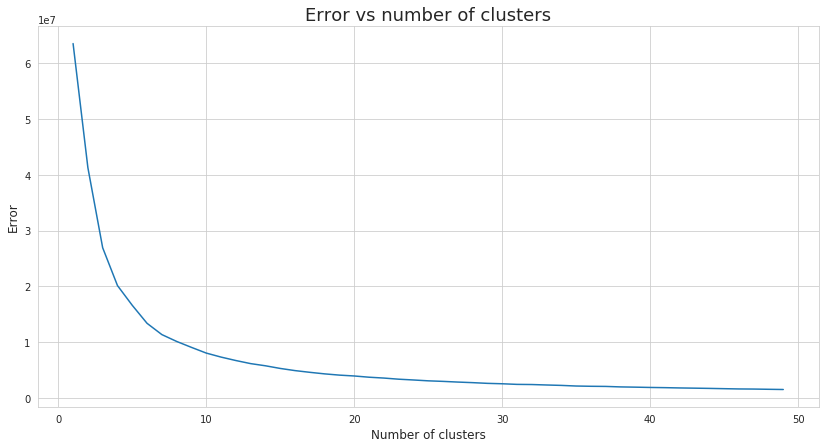

In [16]:
inertia_df = pd.DataFrame()
inertia_df['x'] = range(1,50,1)
inertia_df['error'] = inertias

sns.set_style("whitegrid")
fig = plt.figure(figsize=(14,7))
sns.lineplot(data = inertia_df, x= 'x', y = 'error')
plt.xlabel('Number of clusters', fontsize=12)
plt.ylabel('Error', fontsize=12)
plt.title('Error vs number of clusters', fontsize=18)
plt.show()

It seems that around 12 clusters the curve stabilizes, so let's try to make the fit with that number.

In [17]:
kmeans = KMeans(n_clusters=12, max_iter= 3000)
kmeans.fit(X_embedded)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=3000,
       n_clusters=12, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

We predict with our trained model and our vectors:

In [18]:
y_kmeans = kmeans.predict(X_embedded)

Let's represent the output:

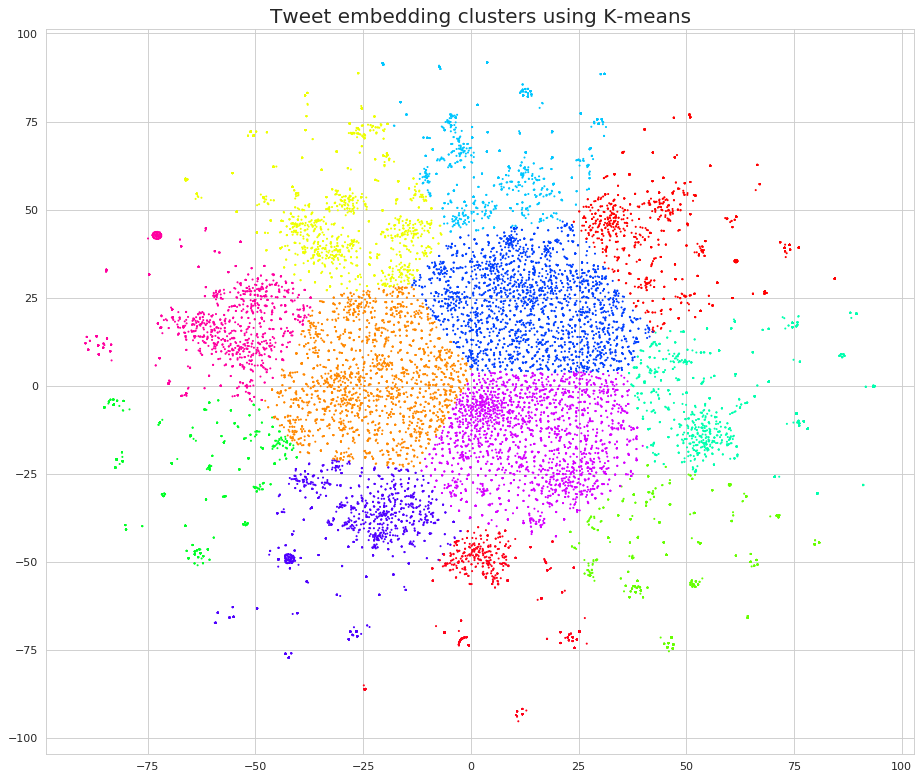

In [19]:
plt.figure(num=None, figsize=(14, 12), dpi=80, facecolor='w', edgecolor='k')
plt.title('Tweet embedding clusters using K-means', fontsize=18)
plt.scatter(x = X_embedded[:,0], y = X_embedded[:,1], c=y_kmeans, s = 0.7, cmap = 'hsv')
plt.show()

Another option would be to use a clustering algorithm to take density into account (as we see some distinct concentrations of tweets), let's try DBSCAN.

In [20]:
dbscan = DBSCAN(eps=2, min_samples=20).fit(X_embedded) # fit
y_dbscan = dbscan.labels_ # predictions

Represent the output.

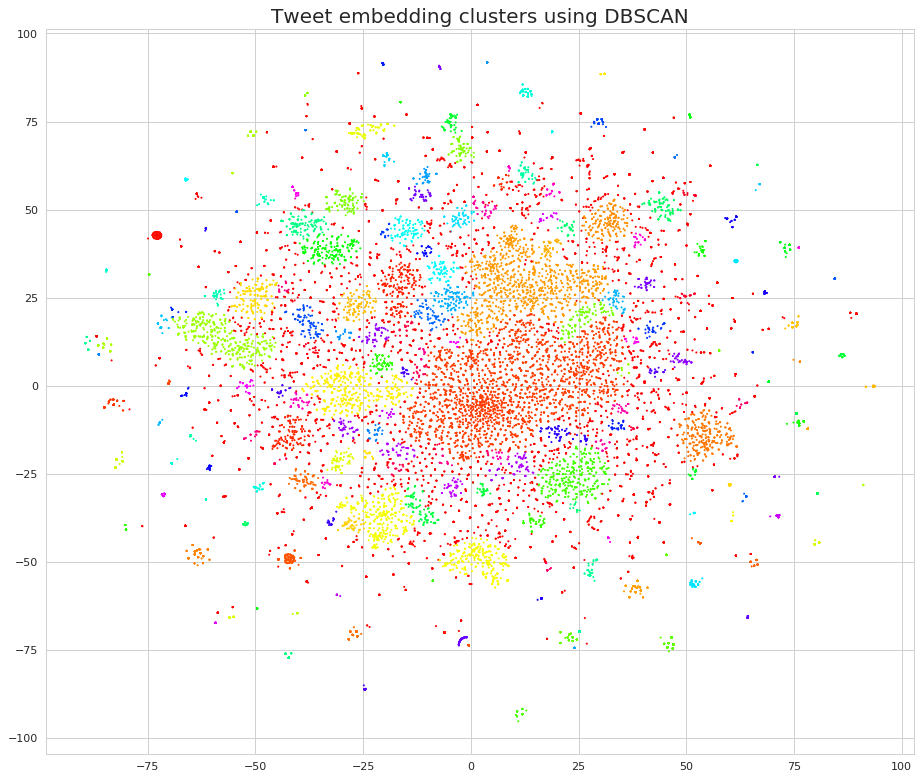

In [21]:
plt.figure(num=None, figsize=(14, 12), dpi=80, facecolor='w', edgecolor='k')
plt.title('Tweet embedding clusters using DBSCAN', fontsize=18)
plt.scatter(x = X_embedded[:,0], y = X_embedded[:,1], c=y_dbscan, s = 0.7, cmap = 'hsv')
plt.show()

The result is much more accurate (intuitively). And there is no need to check the error, since there are many more clusters. However, we are going to stick with k-means clustering for two reasons:

- With K-means we can fix the number of clusters (with DBSCAN the number is triggered up to hundreds, and we are asked for a profile of each one)

- DBSCAN does not assign a cluster to the "outliers", which would make it difficult for us to diversify the output.

Now we are going to try to detect the topics in the conversation of some cluster:

In [22]:
df_tweets_clustered = df_tweets_simp_red.copy().loc[list_embedded_tweets] 
df_tweets_clustered['cluster'] = y_kmeans # Map cluster to original tweet

Let's, for example, display the text for tweets from cluster 9:

In [23]:
df_tweets_clustered[df_tweets_clustered['cluster']==9][['text']].head(20)

text
13   The #TrumpVirus is raging out of control.                                                                                                                                                                                                      
43   Why was this man @933daacb-3481-5762-ac41-96b922a655b4 re-elected into office?                                                                                                                                                                 
55   Fender sales boom as guitar playing surges during the pandemic ‚Äì EAST AUTO¬†NEWS https://t.co/RcVuXXeN00                                                                                                                                        
77   only a straight white privileged male would call them ‚Äúfunctionally equivalent oligarchs‚Äù                                                                                                                                                      
87   I said this months ago!  My husband had it at the end of January, before all the insanity started!  I'm sure we all‚Ä¶ https://t.co/aweR5l6ELK                                                                                                   
112  RT @85bcc777-81ca-5381-8e9d-68c626250ae0: Jaws is on and I just realized it‚Äôs actually an allegory for the pandemic.                                                                                                                           
120  Thanks for being brave enough to expose this#RNFL                                                                                                                                                                                              
121  RT @0b793f95-f92f-5320-b000-5c1305c939fe: Did you watch this? Is your mouth glued? Racism is dividing this country &amp; as the President of South Africa, you have N‚Ä¶                                                                         
137  RT @b934bcfc-c147-52f3-9f91-512b301c00db: "So they seek to destroy [Atlas] because he and the scientific coalition he represents makes it clear that these publi‚Ä¶                                                                              
139  RT @d7dba99e-6c1c-50d2-8592-eb4e425beb55: Italy &amp; Iran ‚Äî two of the places most severely hit initially by the virus ‚Äî are the CCP‚Äôs outposts in the Belt and Road‚Ä¶                                                                         
154  RT @4c742bdd-5114-5cec-9ca7-1426ea4f9466: The [DS] Planned Out A ‚ÄúRUSSIA‚Äù Coup And They Got Caught\n\nThe [DS] Planned Out An Impeachment Coup And They Got Caught‚Ä¶                                                                            
172  Heeeheee YEP SAME                                                                                                                                                                                                                              
180  RT @b8d84ea7-4985-57d0-b91f-9d1d211a8834: i feel like we could expose life goew on to the gp by promoting on tik tok maybe we could make a trend using it as the back‚Ä¶                                                                         
184  If we make it through the coup attempt, this kind of thing would make $1B as a coffee table book                                                                                                                                               
187  RT @89fc2897-68c9-57f3-a7e2-db74e3a73a65: Jesus Alan, if your insightful analysis here is true, we... we might have a pandemic on our hands !! https://t.co/2IZZiErT‚Ä¶                                                                          
194  RT @c7dc16e8-65c3-51a1-96d7-6d7bcc08a05d: We need all decision makers home during a global pandemic: not flying to Washington to spread lies about what #VotersDe‚Ä¶                                                                             
197  RT @d1e9d151-0a14-596a-8317-4726c0c

## Clustering profiling
### RQ 1B

Group by cluster concatenating the lists of terms:

In [24]:
cluster_to_terms_df = df_tweets_clustered.groupby('cluster', as_index=False).agg({'terms': 'sum'})
cluster_to_terms_df

cluster  \
0   0         
1   1         
2   2         
3   3         
4   4         
5   5         
6   6         
7   7         
8   8         
9   9         
10  10        
11  11        

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           terms  
0   [d1c5473151605a69b9316b0f655dba23, 4789a089cb355025a3f94d70bb13bc12, trump, 2020, trump, doesnt, care, either, live, doesnt, care, lo, httpstco8dvcuuk5ui, 7d4d4ab127dc59408ab78c089559887a, peopl, guilti, folli, ruler, need, understand, elect, throug, httpstco61uvybcdlp, be988d7c2d6758e5ab1777e8cbb6ab2, joey, bribe, biden, tweet, warn, octob, 2019, coincid, mani, innoc, peopl, 586a11d8bb815f73a5b99570e1644eeb, damn, turn, cure, rich, wellconnect, knew, anyway, get, back, work, peasant, line, must, go, 71754a9fdd2a502f841a96d02cd1f0f2, time, think, either, 28fcec38faa85249a218d3f199d45208, 933daacb34815762ac4196b922a655b4, cant, stoop, lower, fealti, trump, disregard, const, 0b7b924d0f8d55e988b99923fc7a243f, said, wed, reach, 2000, deathsday, amp, 200000, casesdi, thanksgiv, said, scaremong, well, say, name, show, face, tell, stori, notjustastatist, 55f5163844c558c18fb73255fc738567, 933daacb34815762ac4196b922a655b4, leadership, a659b3548b1e5a91a13c23d7e2ff1084, biden, team, want, repair, relationship, a659b3548b1e5a91a13c23d7e2ff1084, biden, team, want, repair, relationship, httpstcozq5bau3hdj, a16f60964a3656c5aa92316755234ce7, ...]  
1   [bfec9ae2b68c5600bdbc3680c58d1cd, shouldnt, talk, covid, warriorsdoctor, havent, paid, salari, month, instead, random, baba, 1f498fcbb1ba59b29a757b11ee1b080b, 575fa2011eaa5eabb8b5e5834e052316, everi, worker, deserv, safe, work, condit, reckless, disregard, covid19, health, amp, safeti, within, capitol, wall, 478179db9da652b093ad546ba4520c18, ye, honest, physician, state, fact, start, asymptomat, peopl, spread, covid19, even, fa, 1bee7cccf43f53edae9e0eb68f7fc971, 2623b406c87b5756a8a7f2438893c1a9, dept, defens, put, south, dakota, travel, list, ellsworth, afb, personnel, cant, leav, amp, ffb7318950085a02a94f0e6e5b251819, still, celebr, vesak, lockdown, coronaviru, crisi, author, liber, homodeu, vesak, covid19, care, vi, e06e178ff5b15466b920b7ea53c21ab2, pattern, weve, throughout, 2020, everi, time, hear, govt, may, eas, restrict, get, bbc, amp, prolo, today, pandem, day, 253, day, bidenharri, administr, 60, assum, mar, 14, start, adj, ...]                                                                                                                                                                                                       
2   [403e43ea81b65f1bb65c1ab0c0ec6632, break, anoth, 4, wh, aid, includ, andrew, giuliani, today, test, posit, covid19, cb, wh, report, 1e307b9117835e36bdb163b8d2a9cd91, 11d3278a19295992a0e42dd4019a584, fwiw, even, fsu, intent, duck, clemson, dont, want, lose, care, pandem, som, 9fe47738cca55d21942ea02a2e363003, 57, offic, traine, test, posi

For each cluster, count the terms and get the top 5.

In [25]:
cluster_tops_df = cluster_to_terms_df[['cluster']]
top = 5
tops_list = []
for i, row in cluster_to_terms_df.iterrows():
    c = Counter(row['terms'])
    top_terms = c.most_common(top) # compute top 
    top_terms_list = []
    [top_terms_list.append(tupla[0]) for tupla in top_terms] # get just the terms
    tops_list.append(top_terms_list) 
cluster_tops_df['top_5'] = tops_list
cluster_tops_df

cluster                                      top_5
0   0        [trump, covid, biden, elect, back]       
1   1        [covid19, covid, coronaviru, amp, day]   
2   2        [test, covid, covid19, posit, trump]     
3   3        [covid19, america, pandem, harvest, free]
4   4        [get, richer, day, govern, educ]         
5   5        [vaccin, pandem, surviv, kid, fall]      
6   6        [covid, trump, meet, cuomo, emmi]        
7   7        [covid, peopl, get, dont, like]          
8   8        [lockdown, covid19, behind, pleas, wake] 
9   9        [pandem, one, make, amp, us]             
10  10       [case, covid, covid19, death, new]       
11  11       [pandem, life, Í∏∞ÏÇ¨, bt, delux]

This is a very simple comparison of the similarity of the tops using Jaccard:

In [26]:
def jaccard_for_tops(tops):
    count = 0
    jaccards = 0
    for first_top in tops: # get one top
        for second_top in tops: # get another one
            if first_top != second_top:
                intersect_len = len(set(first_top).intersection(set(second_top)))
                union_len = len(set(first_top).union(set(second_top)))
                jaccards += intersect_len/union_len # compute Jaccard
                count += 1 
    return jaccards / count # average Jaccard

Compute similarity:

In [27]:
similarity = jaccard_for_tops(list(cluster_tops_df['top_5']))
print("The average Jaccard similarity of the clusters top 5s  is: {}.".format(round(similarity, 3)))

The average Jaccard similarity of the clusters top 5s  is: 0.065.
